In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


In [9]:
from fastai import *
from fastai.text import *

In [10]:
path = untar_data(URLs.YELP_REVIEWS)
path.ls()

[PosixPath('/tmp/.fastai/data/yelp_review_full_csv/train.csv'),
 PosixPath('/tmp/.fastai/data/yelp_review_full_csv/test.csv'),
 PosixPath('/tmp/.fastai/data/yelp_review_full_csv/readme.txt')]

In [11]:
! cat /tmp/.fastai/data/yelp_review_full_csv/readme.txt

Yelp Review Full Star Dataset

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews full star dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Yelp reviews full star dataset is constructed by randomly taking 130,000 training samples and 10,000 testing samples for each review star from 1 to 5. In total there are 650,000 trainig samples and 50,000 testing samples.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 2 columns in them, corresponding to clas

In [12]:
# Read and see the training data with Pandas
train = pd.read_csv(path/'train.csv', header=None)
train.head(10)

,0,1
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...
5,5,Top notch doctor in a top notch practice. Can'...
6,5,Dr. Eric Goldberg is a fantastic doctor who ha...
7,1,I'm writing this review to give you a heads up...
8,2,Wing sauce is like water. Pretty much a lot of...
9,3,Decent range somewhat close to the city. The ...


In [13]:
# Review example
train.loc[1, 1]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

## DataBlock API

**Question:** Had to keep the `bs` small because kept running out of 13G memory on Kaggle kernels and, in one instance, ran out of CUDA GPU memory. Why did that happen?

In [14]:
data = (TextList.from_csv(path, 'train.csv', cols=1, header=None)
                .split_by_rand_pct(0.2)
                .label_from_df(cols=0)
                .label_for_lm()
                .databunch(bs=16)
       )
print('Done!')

Done!


**Question:** Does the tokenization and numericalization part happen here? Different from the lecture notebook results, where whole text is shown.

In [15]:
data.show_batch()

idx,text
0,9 ] xxbos [ 2 5 311 xxunk ... 81 79 50 9 ] xxbos [ 2 5 xxunk 14 ... 21 5 xxunk 9 ] xxbos [ 2 5 29 48 ... 17 201 47 9 ] xxbos [ 2 13 xxunk 97 ... 15 163 17 26 ] xxbos [ 2 5 29 48 ... xxunk 5 xxunk 9 ] xxbos [ 2 5 219 32 xxunk xxunk
1,[ 2 5 120 15 ... 0 199 xxunk 26 ] xxbos [ 2 5 43 16 34 41 45 9 5 152 66 34 xxunk xxunk 304 5 xxunk xxunk 15 \n 315 75 6 xxunk xxunk 92 xxunk 9 ] xxbos [ 2 5 xxunk 11 ... xxunk 14 xxunk 26 ] xxbos [ 2 5 xxunk 29 ... 62 47 299 26 ] xxbos [ 2
2,xxbos [ 2 13 77 15 ... 33 14 xxunk 9 ] xxbos [ 2 5 45 48 ... 51 xxunk 50 26 ] xxbos [ 2 13 82 54 ... 224 18 400 9 ] xxbos [ 2 5 74 10 ... 5 xxunk xxunk 9 ] xxbos [ 2 5 29 20 80 36 xxunk 76 5 xxunk 9 14 xxunk 123 31 820 192 xxunk 12 199
3,5 29 237 ... xxunk 44 130 9 ] xxbos [ 2 5 xxunk 113 ... 14 73 xxunk 9 ] xxbos [ 2 5 xxunk xxunk ... 19 24 xxunk 9 ] xxbos [ 2 5 xxunk 149 ... xxunk xxunk xxunk 9 ] xxbos [ 2 5 73 xxunk ... 24 xxunk 550 9 ] xxbos [ 2 5 157 157 ... 0 26 26 26 ] xxbos
4,[ 2 5 29 20 ... xxunk 5 xxunk 26 ] xxbos [ 2 13 147 xxunk ... 5 xxunk 5 xxunk ] xxbos [ 2 13 16 82 ... 34 251 17 9 ] xxbos [ 2 5 41 xxunk ... 90 11 77 26 ] xxbos [ 2 5 xxunk 20 ... xxunk 18 xxunk 9 ] xxbos [ 2 5 93 25 ... 514 5 154 9


In [16]:
data.save()

## Language model

**Question:** Why `arch=AWD_LSTM` replaced the `pretrained_model=URLs.WT103`? Documented in [`text.models`](https://docs.fast.ai/text.models.html#AWD_LSTM).

Written like this in [`text.learner` documentation](https://docs.fast.ai/text.learner.html#language_model_learner):

> The model used is given by `arch` and `config`. It can be:
> * `AWD_LSTM` (Merity et al.)
> * `Transformer` decoder (Vaswani et al.)
> * `TransformerXL` (Dai et al.)
> 
> ... At this stage, only the AWD LSTM support `pretrained=True` but we hope to add more pretrained models soon.

In [17]:
learn = language_model_learner(data, arch=AWD_LSTM, drop_mult=0.3)
print('Done!')

Done!


In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


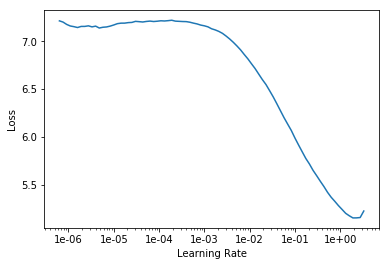

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4, max_lr=slice(1e-03, 1e+00))

epoch,train_loss,valid_loss,accuracy,time
0,4.980043,3.830854,0.412127,12:09
1,4.527194,3.428219,0.418282,12:09
2,2.834497,2.638993,0.483749,12:08
3,2.199892,2.118005,0.549494,12:08


**QUestion:** So this accuracy means the model is guessing the next word of the Yelp review correctly about half the time?

In [21]:
learn.predict('Dr. Goldberg has been very ', 100, temperature=1.1, min_p=0.001)

'Dr. Goldberg has been very  1099 515 149 240 9 ] xxbos [ 2 13 56 32 ... 47 139 78 130 9 ] xxbos [ 2 5 58 29 ... 13 62 47 139 130 26 ] xxbos [ 2 5 74 10 ... 45 60 9 ] xxbos [ 2 5 10 43 ... 17 26 26 26 ] xxbos [ 2 13 37 210 ... 14 47 0 ] xxbos [ 2 5 15 29 ... 10 63 18 ] xxbos [ 2 5 122 84 10 366 48 128 15 210 53 28 94 32 77 139 15 29 48 12'

**Question:** Why am I getting numericalized predictions? How to get the text?

## Classifier

In [22]:
data_cls = (TextList.from_csv(path, 'train.csv', cols=1, header=None, vocab=data.vocab)  # using above language model
                .split_by_rand_pct(0.2)
                .label_from_df(cols=0)
                .databunch(bs=16)
       )
print('Done!')

OSError: [Errno 12] Cannot allocate memory